BBC News Classification Dataset

In [243]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split  # <--- this is essential
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import re

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from sklearn.naive_bayes import MultinomialNB

import seaborn as sns
from sklearn.metrics import confusion_matrix

1.Data Preparation

In [153]:
# Loading training and test data (the dataset is already divided like this)
train_df = pd.read_csv("BBC News Train.csv")
test_df = pd.read_csv("BBC News Test.csv")

In [154]:
# Checking the first few rows
print("Training Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())

Training Data:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Test Data:
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


In [155]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1490, 3)
Test shape: (735, 2)


In [156]:
print("Training categories distribution:")
print(train_df['Category'].value_counts())

Training categories distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


Following this analysis of both the datsets that are offered within the BBC News Classification ds, the rest of this challenge with focus only on the training dataset due to the fact that the provided test set does not include category labels.

In [158]:
#In order to properly train and evaluate the model, a stratified split (80/20) is
#performed on the training dataset, ensuring a balanced representation of the categories.
train_set, val_set = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df['Category']
)

print("Train set size:", train_set.shape)
print("Validation set size:", val_set.shape)

# Check category distribution
print("\nTrain category counts:\n", train_set['Category'].value_counts())
print("\nValidation category counts:\n", val_set['Category'].value_counts())

Train set size: (1192, 3)
Validation set size: (298, 3)

Train category counts:
 Category
sport            277
business         269
politics         219
entertainment    218
tech             209
Name: count, dtype: int64

Validation category counts:
 Category
sport            69
business         67
entertainment    55
politics         55
tech             52
Name: count, dtype: int64


In [251]:
#text preprocessing steps to convert to lowecase, removing the URLs, 
#emails, punctuation, numbers etc, in order for the model to focus on meaningful 
#words for the classification.

stop_words = set(ENGLISH_STOP_WORDS)

def clean_text(text, remove_stopwords=True):
#Lowercase
    text = str(text).lower()
    
#Removes URLs and emails
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    
#Keeps letters only
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = text.split()
    
#Removes stopwords
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    
#Removes single-character tokens
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(tokens)


In [253]:
#Applying cleaning
train_set['clean_text'] = train_set['Text'].apply(clean_text)
val_set['clean_text'] = val_set['Text'].apply(clean_text)

In [255]:
#Showing a few examples
for i in range(3):
    print("Original:", train_set['Text'].iloc[i][:200])
    print("Cleaned: ", train_set['clean_text'].iloc[i][:200])
    print()


Original: winter freeze keeps oil above $50 oil prices carried on rising on wednesday after cold weather on both sides of the north atlantic pushed us crude prices to four-month highs.  freezing temperatures an
Cleaned:  winter freeze keeps oil oil prices carried rising wednesday cold weather sides north atlantic pushed crude prices month highs freezing temperatures heavy snowfalls took crude oil prices past barrel tu

Original: concerns over windows atms cash machine networks could soon be more susceptible to computer viruses  a security firm has warned.  the warning is being issued because many banks are starting to use the
Cleaned:  concerns windows atms cash machine networks soon susceptible computer viruses security firm warned warning issued banks starting use windows operating machines incidents windows viruses disrupted netw

Original: holmes is hit by hamstring injury kelly holmes has been forced out of this weekend s european indoor athletics championships after picking up a 

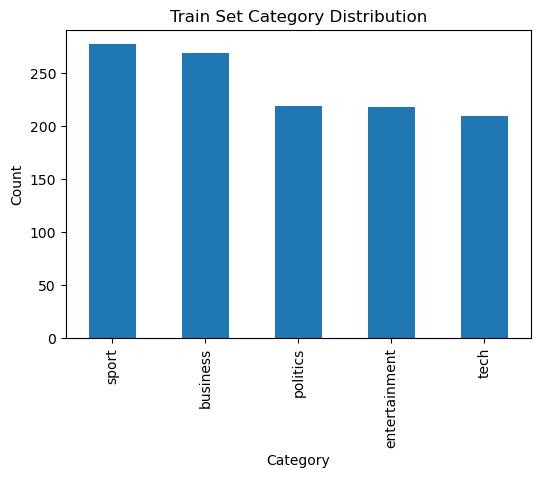

In [188]:
#Ploting category distribution in training set
train_set['Category'].value_counts().plot(kind='bar', figsize=(6,4), title='Train Set Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [190]:
train_set.to_csv('train_clean.csv', index=False)
val_set.to_csv('val_clean.csv', index=False)

print("Clean dataset!")

Clean dataset!


2. EDA

Number of samples per category:
 Category
sport            277
business         269
politics         219
entertainment    218
tech             209
Name: count, dtype: int64


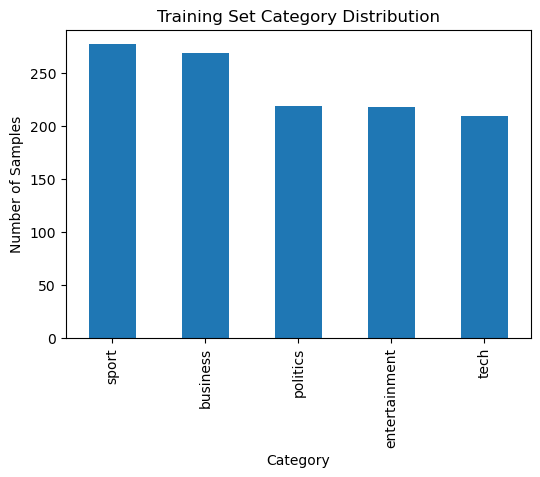

In [193]:
#Showing the ounting of samples per category in the training set again to align 
#with the plots
category_counts = train_set['Category'].value_counts()
print("Number of samples per category:\n", category_counts)

#Ploting it
category_counts.plot(kind='bar', figsize=(6,4), title='Training Set Category Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()

In [195]:
#Checking the most common words 

#Combining all cleaned text in train set
all_words = ' '.join(train_set['clean_text']).split()

#Counting the frequencies
word_freq = Counter(all_words)

#Showing top 20 most common words
print("Top 20 most frequent words:")
print(word_freq.most_common(20))

Top 20 most frequent words:
[('said', 3797), ('mr', 1589), ('year', 1246), ('people', 1099), ('new', 1059), ('time', 692), ('world', 641), ('uk', 603), ('government', 585), ('best', 525), ('years', 514), ('just', 507), ('film', 499), ('make', 487), ('told', 478), ('bn', 472), ('game', 471), ('number', 459), ('like', 440), ('labour', 436)]


In [197]:
#Checking the most common words per category

def top_words(category, n=10):
    texts = train_set[train_set['Category'] == category]['clean_text']
    words = ' '.join(texts).split()
    return Counter(words).most_common(n)

categories = train_set['Category'].unique()
for cat in categories:
    print(f"Top words for category '{cat}':")
    print(top_words(cat))
    print()

Top words for category 'business':
[('said', 869), ('bn', 417), ('year', 363), ('mr', 306), ('market', 234), ('new', 221), ('growth', 209), ('firm', 207), ('economy', 196), ('company', 193)]

Top words for category 'tech':
[('said', 829), ('people', 535), ('mobile', 293), ('new', 272), ('mr', 269), ('technology', 238), ('use', 221), ('year', 218), ('net', 215), ('users', 212)]

Top words for category 'sport':
[('said', 503), ('game', 295), ('england', 281), ('year', 262), ('time', 227), ('win', 226), ('world', 226), ('team', 174), ('cup', 173), ('ireland', 169)]

Top words for category 'entertainment':
[('said', 462), ('film', 453), ('best', 349), ('year', 259), ('music', 203), ('new', 178), ('number', 158), ('awards', 156), ('actor', 137), ('director', 136)]

Top words for category 'politics':
[('said', 1134), ('mr', 878), ('labour', 417), ('government', 358), ('blair', 347), ('election', 344), ('party', 330), ('people', 316), ('minister', 225), ('new', 223)]



3. Model training

3.1 Logistic Regression will be used for the first model

In [207]:
#First of all before the model we use TF-IDF to convert the text to numbers

#Initializing the vectorizer
tfidf = TfidfVectorizer(max_features=5000)

X_train = tfidf.fit_transform(train_set['clean_text'])
X_val = tfidf.transform(val_set['clean_text'])

#Targeting labels
y_train = train_set['Category']
y_val = val_set['Category']

print("TF-IDF shapes -> X_train:", X_train.shape, ", X_val:", X_val.shape)

TF-IDF shapes -> X_train: (1192, 5000) , X_val: (298, 5000)


In [211]:
# Initializing the model
lr_model = LogisticRegression(max_iter=1000)

#Training on training set
lr_model.fit(X_train, y_train)

#Predicting on validation set
y_pred = lr_model.predict(X_val)

#Evaluating
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Validation Accuracy: 0.9664429530201343

Classification Report:
                precision    recall  f1-score   support

     business       0.94      0.97      0.96        67
entertainment       0.96      1.00      0.98        55
     politics       0.98      0.93      0.95        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macro avg       0.97      0.96      0.97       298
 weighted avg       0.97      0.97      0.97       298



3.2 Niave Bayes will be used for another model so we can compare the results (Out of curiosity)

In [219]:
#Initializing the model 
nb_model = MultinomialNB()

##Train on the training set and predict on the validation set
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_val)

#Evaluating the model
accuracy_nb = accuracy_score(y_val, y_pred_nb)
print("Validation Accuracy:", accuracy_nb)
print("\nClassification Report:\n", classification_report(y_val, y_pred_nb))

Validation Accuracy: 0.9731543624161074

Classification Report:
                precision    recall  f1-score   support

     business       0.94      0.97      0.96        67
entertainment       1.00      1.00      1.00        55
     politics       0.96      0.93      0.94        55
        sport       1.00      1.00      1.00        69
         tech       0.96      0.96      0.96        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



4. Interactive Script

In [233]:
def interactive_prediction_test(lr_model, nb_model, vectorizer):
    print("Prediction Script Test")
    print("Type 'exit' to quit.\n")
    
    while True:
        user_input = input("Enter a sentence: ")
        if user_input.lower() == 'exit':
            print("Exiting prediction test.")
            break
        
#Cleaning and transform input
        cleaned_text = clean_text(user_input)
        features = vectorizer.transform([cleaned_text])
        
#Predicting
        pred_lr = lr_model.predict(features)[0]
        pred_nb = nb_model.predict(features)[0]
        
#Displaying results
        print(f"Logistic Regression predicts: {pred_lr}")
        print(f"Naive Bayes predicts:        {pred_nb}\n")


In [237]:
#This runs the test 
interactive_prediction_test(lr_model, nb_model, tfidf)

Prediction Script Test
Type 'exit' to quit.



Enter a sentence:  the new smartphone release shows amazing advancements in AI technology.


Logistic Regression predicts: tech
Naive Bayes predicts:        tech



Enter a sentence:  The government passed a new economic reform bill yesterday.


Logistic Regression predicts: business
Naive Bayes predicts:        business



Enter a sentence:  The singer released her latest album, and fans are raving about it.


Logistic Regression predicts: entertainment
Naive Bayes predicts:        entertainment



Enter a sentence:  The prime minister met with international leaders to discuss climate change.


Logistic Regression predicts: politics
Naive Bayes predicts:        politics



Enter a sentence:  The football team won the championship after a thrilling final match.


Logistic Regression predicts: sport
Naive Bayes predicts:        sport



Enter a sentence:  The actor invested in a new sports franchise.


Logistic Regression predicts: entertainment
Naive Bayes predicts:        entertainment



Enter a sentence:  The government announced new regulations for streaming platforms.


Logistic Regression predicts: business
Naive Bayes predicts:        business



Enter a sentence:  The tech company sponsors the national football team this season


Logistic Regression predicts: sport
Naive Bayes predicts:        sport



Enter a sentence:  exit


Exiting prediction test.


In [245]:
#Bonus part - Confusion matrices for both of the models

# Logistic Regression
y_pred_lr = lr_model.predict(X_val)
cm_lr = confusion_matrix(y_val, y_pred_lr, labels=train_set['Category'].unique())

# Naive Bayes
y_pred_nb = nb_model.predict(X_val)
cm_nb = confusion_matrix(y_val, y_pred_nb, labels=train_set['Category'].unique())

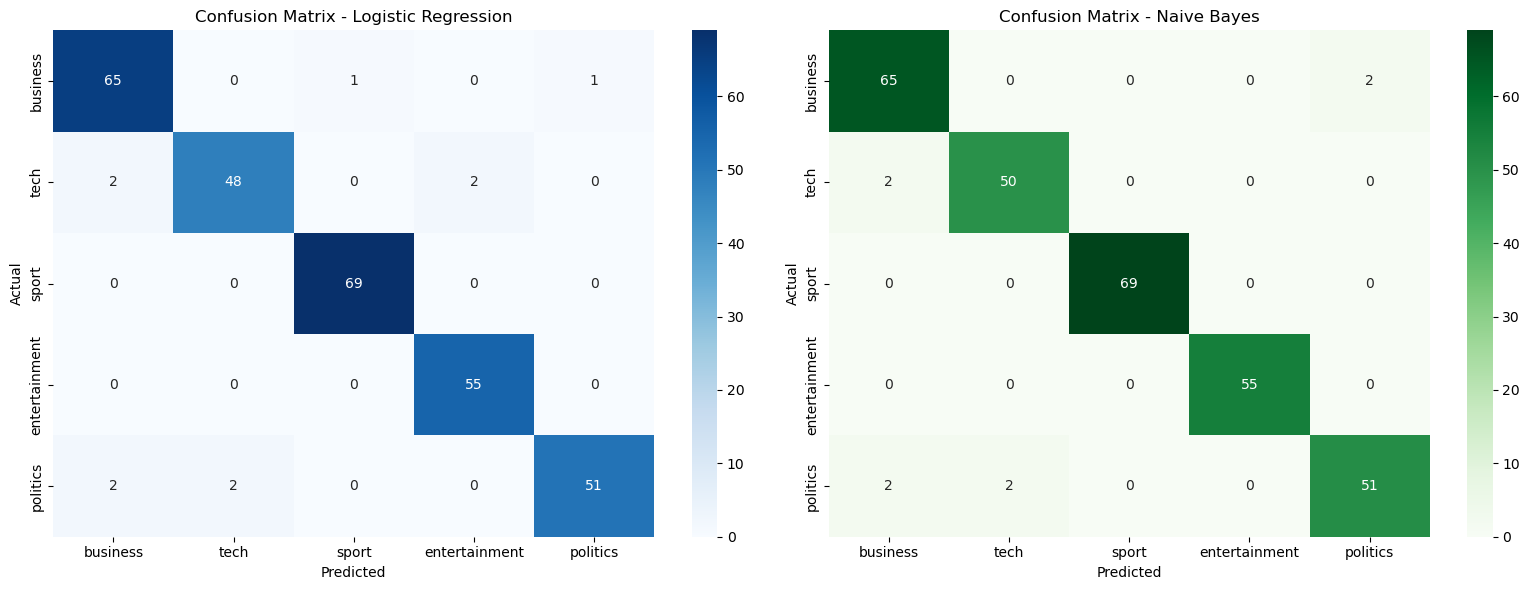

In [247]:
categories = train_set['Category'].unique()

fig, axes = plt.subplots(1, 2, figsize=(16,6))

#Logistic Regression model
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Logistic Regression')

#Naive Bayes model
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=categories, yticklabels=categories, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix - Naive Bayes')

plt.tight_layout()
plt.show()

Conclusion: 

Based on what the confusion matrices are showing, moslty high diagonal numbers 
and only a few off-diagonal misclassifications, it can be concluded that both models are very strong. 